# People like you also like Machine Learning meetups

By Josef Lindman Hörnlund, Modulai AB.

Based on 

## Metadata Embeddings for User and Item Cold-start

By Maciej Kula, from Lyst.

As implemented in https://github.com/lyst/lightfm.

And of course Rendle's original research on factorisation machines (for example https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)

## Varational autoencoders for collaborative filtering

This part of the notebook is inspired completely by Dawen Liang et. al. (https://arxiv.org/abs/1802.05814) (Netflix, Google AI and MIT) and their notebook for Tensorflow here (https://github.com/dawenl/vae_cf/).

In [ ]:
# Import PyTorch 
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as t_data
import torch

# Pandas is needed for handling the dataset
import pandas as pd

# LightFM is used for training factorising machine
from lightfm import LightFM

# LightFM data is used for creating the sparse author-token weight matrix
from lightfm.data import Dataset

# Evaluation for recall and precision at k metrics
import lightfm.evaluation as ev

# stopwords to exclude from titles
from nltk.corpus import stopwords

# Date handling
import datetime as dt

# Matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Numpy is always needed
import numpy as np

import os

In [6]:
# Plot style and palette
sns.set_style("darkgrid")
palt = sns.color_palette("husl", 8)

![Intro](intro.png)


## Download data

We are using https://github.com/Mahdisadjadi/arxivscraper to download arXiv articles.

In [7]:
def date_str_to_dt(s):
    return dt.datetime.strptime(s, "%Y-%m-%d")

# I had to modify this repo but don't remember what i did. Probably include first names of authors.
os.chdir("/Users/josef/github.com/mahda/arxivscraper")
import arxivscraper

# Download articles from arxiv
scraper = arxivscraper.Scraper(date_from='2008-05-28',date_until='2018-08-14', category="stat")

t = scraper.scrape()

http://export.arxiv.org/oai2?verb=ListRecords&from=2008-05-28&until=2018-08-14&metadataPrefix=arXiv&set=stat
fetching up to  1000 records...
fetching up to  2000 records...
fetching up to  3000 records...
fetching up to  4000 records...
fetching up to  5000 records...
fetching up to  6000 records...
fetching up to  7000 records...
fetching up to  8000 records...
fetching up to  9000 records...
fetching up to  10000 records...
fetching up to  11000 records...
fetching up to  12000 records...
fetching up to  13000 records...
fetching up to  14000 records...
fetching up to  15000 records...
fetching up to  16000 records...
fetching up to  17000 records...
fetching up to  18000 records...
fetching up to  19000 records...
fetching up to  20000 records...
fetching up to  21000 records...
fetching up to  22000 records...
fetching up to  23000 records...
fetching up to  24000 records...
fetching up to  25000 records...
fetching up to  26000 records...
fetching up to  27000 records...
fetching 

In [12]:
# Show how the data look like
t[0]

{'title': 'on generalized entropy measures and pathways',
 'id': '0704.0326',
 'abstract': 'product probability property, known in the literature as statistical independence, is examined first. then generalized entropies are introduced, all of which give generalizations to shannon entropy. it is shown that the nature of the recursivity postulate automatically determines the logarithmic functional form for shannon entropy. due to the logarithmic nature, shannon entropy naturally gives rise to additivity, when applied to situations having product probability property. it is argued that the natural process is non-additivity, important, for example, in statistical mechanics, even in product probability property situations and additivity can hold due to the involvement of a recursivity postulate leading to a logarithmic function. generalizations, including mathai\'s generalized entropy are introduced and some of the properties are examined. situations are examined where mathai\'s entropy le

In [13]:
# Split articles in training and validation set

train_val_split = date_str_to_dt('2018-03-01')
train_set = []
val_set = []
for a in t:
    if (date_str_to_dt(a['created']) - train_val_split).days < 0:
        train_set.append(a)
    else:
        val_set.append(a)

In [14]:
# Flatten the return json to tabular format

bad_tokens = [",", ":", " ", "-", "!", "\"", "(", ")"]
stop = stopwords.words('english') + ["via", "using", "based", " ", "towards"]

# Parse arxiv data and create a list of words in the article title, and authors
def parser(articles):
    unique_tags = set()
    pairs = []
    for paper in articles:
        title_words = [a for a in paper['title'].split(" ") if a not in stop]
        authors = paper['authors']
        tags = paper['categories']
        [unique_tags.add(a) for a in tags.split(" ")]
        doi = paper['doi']
        url = paper['url']
        released = paper['created']
        # Remove some strange characters from title words to 
        for n in title_words:
            n_cleaned = "".join([c for c in n if c not in bad_tokens])
            for m in authors:
                if len(n_cleaned) > 0:
                    pairs.append([n_cleaned, m, tags, doi, url, released])
    columns = ["token", "author", "tags", "doi", "url", "released"]
    pairs_df = pd.DataFrame(pairs, columns=columns)
    pairs_df['released'] = pd.to_datetime(pairs_df['released'])
    return unique_tags, pairs_df

unique_tags_train, pairs_train = parser(train_set)
unique_tags_val, pairs_val = parser(val_set)

unique_tags = unique_tags_train.union(unique_tags_val)

In [15]:
print("Training set size: " + str(pairs_train.shape))
print("Validation set size: " + str(pairs_val.shape))

print("Training to validation split: " + str(pairs_train.shape[0]/(pairs_train.shape[0] + pairs_val.shape[0])))

pairs_train.head()

Training set size: (683766, 6)
Validation set size: (113818, 6)
Training to validation split: 0.8572965355373228


token         author                                tags  \
0  generalized   a. m. mathai  math.st cond-mat.stat-mech stat.th   
1  generalized  h. j. haubold  math.st cond-mat.stat-mech stat.th   
2      entropy   a. m. mathai  math.st cond-mat.stat-mech stat.th   
3      entropy  h. j. haubold  math.st cond-mat.stat-mech stat.th   
4     measures   a. m. mathai  math.st cond-mat.stat-mech stat.th   

                           doi                              url   released  
0  10.1016/j.physa.2007.06.047  https://arxiv.org/abs/0704.0326 2007-04-03  
1  10.1016/j.physa.2007.06.047  https://arxiv.org/abs/0704.0326 2007-04-03  
2  10.1016/j.physa.2007.06.047  https://arxiv.org/abs/0704.0326 2007-04-03  
3  10.1016/j.physa.2007.06.047  https://arxiv.org/abs/0704.0326 2007-04-03  
4  10.1016/j.physa.2007.06.047  https://arxiv.org/abs/0704.0326 2007-04-03

In [16]:
df = pd.DataFrame(list(map(lambda x: x.split("."), unique_tags)), 
                  columns = ["cat", "subcat"])
df.cat.value_counts()

cs          39
math        29
physics     21
q-bio       10
cond-mat     9
q-fin        9
astro-ph     7
stat         6
nlin         5
econ         3
eess         3
math-ph      1
quant-ph     1
hep-th       1
hep-ex       1
nucl-ex      1
nucl-th      1
gr-qc        1
hep-ph       1
hep-lat      1
Name: cat, dtype: int64

Text(0,0.5,'Uses')

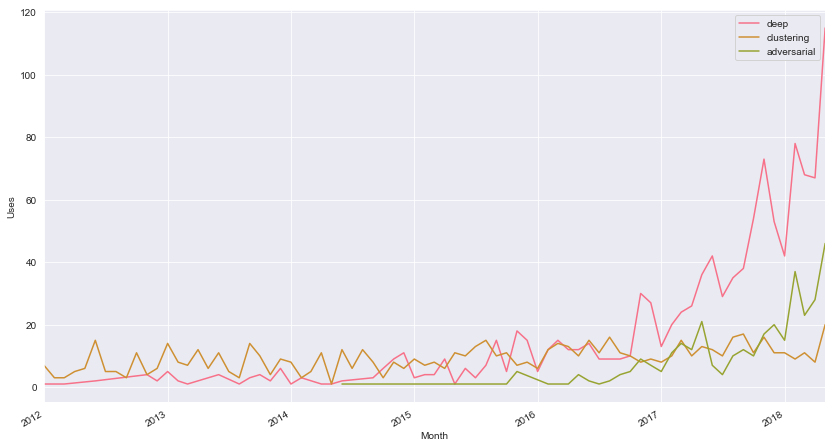

In [17]:
# Let us check some word popularity

pairs_tot = pd.concat([pairs_train, pairs_val], axis=0)

pairs_tot['month'] = pairs_tot.released.astype('datetime64[M]')

fig, ax = plt.subplots(figsize=(14, 8))
for n, a in enumerate(["deep", "clustering", "adversarial"]):
    d1 = pairs_tot[pairs_tot.token == a].groupby("month").url.nunique().reset_index()
    d1.plot(ax=ax, x="month", y="url", c=palt[n], label=a)
plt.xlim(('2012-01-01', '2018-05-01'))
plt.xlabel("Month")
plt.ylabel("Uses")

## Recommendation systems

* Let $\mathbf{x}_u$ be a vector with counts for all user $u$'s previous authors (skip time index following Liang et.al} but up to time t.
* Let $x_{u, t+1}$ we the next token the author will write about.
* Let $v_u$ be the feature vector for user $u$ known at time $t$
* Let $w_k$ be the feature vector for item $k$.
\begin{equation}
p(x_{u, t+1} = k|\mathbf{v}_u, \mathbf{w}_k, \mathbf{x}_u)
\end{equation}

Collaborative filtering => Skipping user and item features (cold start problem for both users and items)

Content based => Skipping item histories (worse than CF when there are many users).

Otherwise it is called a hybrid approach!

### Collaborative filtering

Classic collaborative filtering often done with _matrix factorisation_:
* This is equivalent to finding embeddings $f_{\theta}$ of users and items into some space $\mathbb{R}^k$:
\begin{equation}
f_{\theta} : \mathcal{S} \rightarrow \mathbb{R}^k
\end{equation}
where $\mathcal{S}$ is the set of of all items and users.

Our estimation of the conditional distribution above becomes the (normalised) scalar product:
\begin{equation}
p(x_{u, t+1} = k|\mathbf{v}_u, \mathbf{w}_k, \mathbf{x}_u) = p(x_{u, t+1} = k|\mathbf{x}_u) = f_{\theta}(u) \cdot f_{\theta}(k)
\end{equation}

The learning problem becomes estimating parameters $\theta$ from the data.

![Collaborative filtering](cf.png)

* Note that a perfect factorisation is useless, since we don't gain information from that.

# Factorising machines

\begin{equation}
y(x) = f(b_0 + \sum_i b_i x^i + \sum_i \sum_j x^i x^j \ f_{\theta}(i) \cdot f_{\theta}(j) )
\end{equation}
where 
* $a_0$ is the global bias, 
* $b_i$ are feature biases, and 
* $(f_{\theta}(i) \cdot f_{\theta}(j))$ is now the scalar product of feature embeddings.
* $f$ is an optional "activation function", such as the identity function or the sigmoid.

Our set $\mathcal{S}$ is the set of items, users _and_ features. 

And the model could potentially contain higher order interactions as well.

It is the embeddings $v$, and the biases $b$, we learn when training. We will look at those in detail below.

### LightFM restriction

https://arxiv.org/abs/1507.08439

In the LightFM case, only weighted sums of user and item features are considered, i.e.

\begin{equation}
y(x) = f(b_0 + \sum_i b_i x^i + (\sum_i x_i v_i) \cdot (\sum_j x_j v_j))
\end{equation}

Hence the big simplification here is that there is only one scalar product evaluated per interaction.

In [18]:
#
# Build dataset for model training
#
# First we find all token/author pairs
#

counts = pairs_train.groupby(["token", "author"]).size().reset_index()
counts_val = pairs_val.groupby(["token", "author"]).size().reset_index()

In [19]:
counts.sort_values(0, ascending=False).head(10)

token               author   0
47858     bayesian      david b. dunson  31
47633     bayesian  christian p. robert  29
133377     designs         holger dette  29
95015   confidence         paul kabaila  28
365693    networks        yoshua bengio  24
342611      models        mathias drton  24
264505   intervals         paul kabaila  24
347210       monte           ajay jasra  23
283649    learning     masashi sugiyama  23
65624        carlo           ajay jasra  23

In [20]:
#
# Item and user feature matrix
#

# Create a feature column for each unique tag
#
# TODO: Speed up!
# TODO: Remove tags that are very uncommon, this slows down the training a lot I think.
tag_list = [pairs_train.tags.str.find(a) > 0 for a in unique_tags]
tags_df = pd.concat(tag_list, axis=1)
tags_df.columns = unique_tags

pairs_train = pd.concat([pairs_train, tags_df], axis=1)

item_tags = pairs_train.groupby(["token"]).apply(lambda x: x[list(unique_tags)].mean())
user_tags = pairs_train.groupby(["author"]).apply(lambda x: x[list(unique_tags)].mean())

In [21]:
item_tags.sample(10).head()

math.oa  q-bio.nc  math.ds  physics.comp-ph  math.rt  \
token                                                                   
drought              0.0       0.0      0.0              0.0      0.0   
conflicting          0.0       0.0      0.0              0.0      0.0   
x1                   0.0       0.0      0.0              0.0      0.0   
singleparticle       0.0       0.0      0.0              0.0      0.0   
birthdeathshift      0.0       0.0      0.0              0.0      0.0   

                  stat.me  cs.it  hep-ex  math.sp  stat.ml   ...     \
token                                                        ...      
drought          0.133333    0.0     0.0      0.0      0.6   ...      
conflicting      0.000000    0.0     0.0      0.0      0.0   ...      
x1               1.000000    0.0     0.0      0.0      0.0   ...      
singleparticle   0.000000    0.0     0.0      0.0      0.0   ...      
birthdeathshift  0.000000    0.0     0.0      0.0      0.0   ...      

                 physics.optics  math.at  cs.ds  cond-mat.soft  \
token                                                            
drought                     0.0      0.0    0.0            0.0   
conflicting                 0.0      0.0    0.0            0.0   
x1                          0.0      0.0    0.0            0.0   
singleparticle              0.0      0.0    0.0            0.0   
birthdeathshift             0.0      0.0    0.0            0.0   

                 cond-mat.mes-hall  cs.ai  q-bio.qm  nucl-th  cs.pf  math.it  
token                                                                         
drought                        0.0    0.0       0.0      0.0    0.0      0.0  
conflicting                    0.0    0.0       0.0      0.0    0.0      0.0  
x1                             0.0    0.0       0.0      0.0    0.0      0.0  
singleparticle                 0.0    0.0       0.0      0.0    0.0      0.0  
birthdeathshift                0.0    0.0       0.0      0.0    0.0      0.0  

[5 rows x 150 columns]

In [22]:
user_tags.sample(10).head()

math.oa  q-bio.nc  math.ds  physics.comp-ph  math.rt  \
author                                                                      
chansoo lee              0.0   0.00000      0.0              0.0      0.0   
akara supratak           0.0   0.00000      0.0              0.0      0.0   
danilo bzdok             0.0   0.46875      0.0              0.0      0.0   
hans-werner van wyk      0.0   0.00000      0.0              0.0      0.0   
tahereh dehdarirad       0.0   0.00000      0.0              0.0      0.0   

                     stat.me  cs.it  hep-ex  math.sp  stat.ml   ...     \
author                                                          ...      
chansoo lee              0.0    0.0     0.0      0.0   1.0000   ...      
akara supratak           0.0    0.0     0.0      0.0   0.4375   ...      
danilo bzdok             0.0    0.0     0.0      0.0   0.1250   ...      
hans-werner van wyk      0.0    0.0     0.0      0.0   0.0000   ...      
tahereh dehdarirad       0.0    0.0     0.0      0.0   0.0000   ...      

                     physics.optics  math.at  cs.ds  cond-mat.soft  \
author                                                               
chansoo lee                     0.0      0.0    0.0            0.0   
akara supratak                  0.0      0.0    0.0            0.0   
danilo bzdok                    0.0      0.0    0.0            0.0   
hans-werner van wyk             0.0      0.0    0.0            0.0   
tahereh dehdarirad              0.0      0.0    0.0            0.0   

                     cond-mat.mes-hall  cs.ai  q-bio.qm  nucl-th  cs.pf  \
author                                                                    
chansoo lee                        0.0    0.0       0.0      0.0    0.0   
akara supratak                     0.0    0.0       0.0      0.0    0.0   
danilo bzdok                       0.0    0.0       0.0      0.0    0.0   
hans-werner van wyk                0.0    0.0       0.0      0.0    0.0   
tahereh dehdarirad                 0.0    0.0       0.0      0.0    0.0   

                     math.it  
author                        
chansoo lee              0.0  
akara supratak           0.0  
danilo bzdok             0.0  
hans-werner van wyk      0.0  
tahereh dehdarirad       0.0  

[5 rows x 150 columns]

In [60]:
# LightFM requires items on a certain form so create lists of the item/user pairs
# 
# TODO: Speed up!

item_feature_list = []
user_feature_list = []
for a in list(unique_tags):
    i_list = [(i, {a: x[a]}) for i, x in item_tags.iterrows() if x[a] > 0]
    u_list = [(i, {a: x[a]}) for i, x in user_tags.iterrows() if x[a] > 0]
    # Create flattened lists
    item_feature_list = item_feature_list + i_list
    user_feature_list = user_feature_list + u_list

In [65]:
# Build LightFM embeddings

d = Dataset()

unique_users = counts['author'].drop_duplicates()
unique_items = counts['token'].drop_duplicates()

d.fit(users=unique_users,
      items=unique_items,
      user_features=unique_items.tolist() + list(unique_tags), 
      item_features=list(unique_tags))

# Interactions matrix builds the standard CF matrix to be factorised
# Weights are ignored (i.e. number of times a user has interacted with an item, we do it binary)
(interactions, weights) = d.build_interactions(((x['author'], x['token'], x[0]) for i, x in counts.iterrows()))

user_item_interaction = [(x['author'], {x['token']: 1}) for i, x in counts.iterrows()]

In [66]:
item_matrix = d.build_item_features(item_feature_list)

In [67]:
user_matrix = d.build_user_features(user_feature_list + user_item_interaction)

In [68]:
# Number items feature interactions
len(item_matrix.data)

106879

In [69]:
# Users plus items plus 150 features
user_matrix.shape

(42264, 62925)

# Ranking loss

From LightFM documentation:

* WARP: Weighted Approximate-Rank Pairwise [2] loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

In [101]:
# Train model the Light FM model
#
# Training is done with stochastic gradient descent: adagrad is the default

model = LightFM(loss='warp', no_components=10, user_alpha=0.00001, item_alpha=0.00001)
model.fit(interactions, user_matrix, item_matrix, epochs=30, num_threads=2, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [102]:
# Validate the model by looking at authors and tokens common between
# training and and validation set

# Intersection of authors
common_authors = set(pairs_val.author).intersection(pairs_train.author)

# Intersection of items
common_items = set(pairs_val.token).intersection(pairs_train.token)


counts_val = counts_val[counts_val.author.isin(common_authors)\
                        & counts_val.token.isin(common_items)]

(interactions_test, weights_test) = d.build_interactions(((x['author'], x['token'], x[0])\
                                                          for i, x in counts_val.iterrows()))

user_item_interaction_test = [(x['author'], {x['token']: 1}) for i, x in counts_val.iterrows()]

item_matrix_test = d.build_item_features([uf for uf in item_feature_list if uf[0] in common_items])
user_matrix_test = d.build_user_features(user_item_interaction_test\
                                         + [uf for uf in user_feature_list if uf[0] in common_authors])

# Validation metrics

## Precision at k

Let algorithm pick top K items from validation set, and check how many of those chosen are positive (i.e. chosen by the user).


## Recall at k

Let algorithm pick top K items from validation set, and check how many of those chosen are positive out of the total number of positives.

## AUC

For each user, let K go from 1 to items chosen in test set and draw ROC curve, i.e. a point for precision and recall at every point (k) on the curve.

Note that false negative rate shows up in the AUC, and as numbers of negatives is usually very high, AUC is usually very high as well.

"the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example."

# Training set metrics

In [103]:
print("Training precision at k: "  + str(ev.precision_at_k(model, 
                                                           interactions, 
                                                           user_features=user_matrix, 
                                                           item_features=item_matrix).mean()))

Training precision at k: 0.1664348


In [104]:
print("Training recall at k: " + str(ev.recall_at_k(model,
                                                    interactions, 
                                                    user_features=user_matrix, 
                                                    item_features=item_matrix).mean()))

Training recall at k: 0.14674619146137882


In [105]:
print("Training AUC: " + str(ev.auc_score(model,
                                          interactions,
                                          user_features=user_matrix,
                                          item_features=item_matrix).mean()))

Training AUC: 0.97009486


# Validation set metrics

In [106]:
print("Validation precision at k: " + str(ev.precision_at_k(model,
                                                            interactions_test, 
                                                            user_features=user_matrix_test, 
                                                            item_features=item_matrix_test).mean()))

Validation precision at k: 0.096061625


In [107]:
print("Validation recall at k: " + str(ev.recall_at_k(model,
                                                      interactions_test,
                                                      user_features=user_matrix_test,
                                                      item_features=item_matrix_test).mean()))

Validation recall at k: 0.12036681022502116


In [108]:
print("Training AUC: " + str(ev.auc_score(model,
                                          interactions_test, 
                                          user_features=user_matrix_test, 
                                          item_features=item_matrix_test).mean()))

Training AUC: 0.96174586


In [109]:
# Validate on tokens not seen, using features from training set

counts_val_not_seen = counts_val.merge(counts, on=["token","author"], how="left")
counts_val_not_seen = counts_val_not_seen[pd.isna(counts_val_not_seen["0_y"])]

(interactions_test2, weights_test2) = d.build_interactions(((x['author'], x['token'], 1)\
                                                            for i, x in counts_val_not_seen.iterrows()))

user_item_interaction_test2 = [(x['author'], {x['token']: 1}) for i, x in counts_val_not_seen.iterrows()]

# Note that features are the same as from training set to "make it more realistic"
item_matrix_test2 = d.build_item_features([uf for uf in item_feature_list if uf[0] in set(counts_val_not_seen.token)])
user_matrix_test2 = d.build_user_features(user_item_interaction_test2\
                                          + [uf for uf in user_feature_list if uf[0] in set(counts_val_not_seen.author)])

In [110]:
print("Validation precision at k: " + str(ev.precision_at_k(model, 
                                                            interactions_test2, 
                                                            train_interactions=interactions, 
                                                            user_features=user_matrix_test2, 
                                                            item_features=item_matrix_test2, k=10).mean()))

Validation precision at k: 0.05112915


In [111]:
print("Validation recall at k: " + str(ev.recall_at_k(model, 
                                                      interactions_test2, 
                                                      train_interactions=interactions, 
                                                      user_features=user_matrix_test2, 
                                                      item_features=item_matrix_test2, k=10).mean()))

Validation recall at k: 0.08109514165490567


In [112]:
print("Validation AUC: " + str(ev.auc_score(model, 
                                            interactions_test2, 
                                            train_interactions=interactions, 
                                            user_features=user_matrix_test2, 
                                            item_features=item_matrix_test2).mean()))

Validation AUC: 0.95532745


0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'Recall')

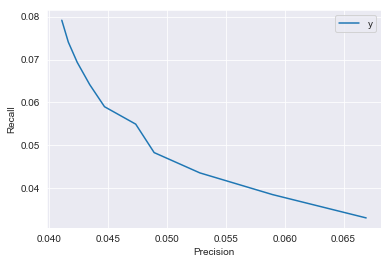

In [86]:
roc_curve=[]
for k in range(10):
    print("Run :" + str(k))
    prec = ev.precision_at_k(model, interactions_test2,
                             train_interactions=interactions,
                             user_features=user_matrix_test2,
                             item_features=item_matrix_test2, k=k+3).mean()
    rec = ev.recall_at_k(model,
                         interactions_test2,
                         train_interactions=interactions,
                         user_features=user_matrix_test2,
                         item_features=item_matrix_test2, k=k+3).mean()
    roc_curve.append([prec, rec])

pd.DataFrame(roc_curve, columns=["x", "y"]).plot(x="x", y="y")
plt.xlabel("Precision")
plt.ylabel("Recall")

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Count')

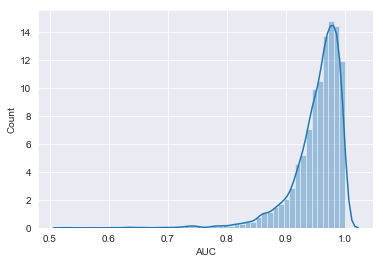

In [87]:
aucs=ev.auc_score(model, 
                  interactions_test2, 
                  train_interactions=interactions, 
                  user_features=user_matrix_test2, 
                  item_features=item_matrix_test2)

sns.distplot(aucs)
plt.xlabel("AUC")
plt.ylabel("Count")

In [158]:
# Some xtra fun stuff

token_mappings = dict([[k, v] for v, k in d.mapping()[3].items()])

#test_author = 'geoffrey e. hinton'
#test_author = 'yann lecun'
test_author = 'jerome h. friedman'

words_used = np.unique(pairs_train[pairs_train.author==test_author].token)

(interactions_test, weights_test) = d.build_interactions(((test_author, x, 1)\
                                                          for x in np.unique(pairs_train.token) if x not in words_used))

item_matrix_test = d.build_item_features(item_feature_list)
user_matrix_test = d.build_user_features([uf for uf in user_feature_list if uf[0] == test_author]\
                                         + [ui for ui in user_item_interaction if ui[0] == test_author])

ranks = model.predict_rank(interactions_test, user_features=user_matrix_test, item_features=item_matrix_test)
ranks.data *= ranks.data < 20
print([token_mappings[a] for a in ranks.nonzero()[1]])

['analysis', 'application', 'approach', 'bayesian', 'classification', 'estimation', 'inference', 'methods', 'model', 'modeling', 'models', 'multiple', 'networks', 'prediction', 'regression', 'selection', 'statistical', 'time']


In [92]:
# Author similarity

print(np.dot(model.user_embeddings[d.mapping()[0]['jerome h. friedman']], 
             model.user_embeddings[d.mapping()[0]['yann lecun']]))

print(np.dot(model.user_embeddings[d.mapping()[0]['geoffrey e. hinton']], 
       model.user_embeddings[d.mapping()[0]['yann lecun']]))

0.029361675
0.108533554


In [ ]:
#So far so good - now let's go non-linear! But first take a step back.

# Note to self: remember to explain why the model below: neural CF etc

Let's say we have a (graphical) model with hidden variables (i.e stochastic variables that we can't observe). 

\begin{equation}
p(\mathbf{x}|\mathbf{z})
\end{equation}

_Example: We want to infer the income (z) of the owners of cars, but we only observe the car (x)._

In our case $x$ is the click history, and $z$ the embedding of click histories into $\mathbb{R}^k$.

Inference is done by estimating the posterior distribution
\begin{equation}
p(\mathbf{z}|\mathbf{x}) = \frac{p(\mathbf{x}|\mathbf{z}) p(\mathbf{z})}{p(\mathbf{x})}
\end{equation}
i.e. the probability of the hidden variables, given the data.

Any kind of analytic solution is most likely "untractable" and even many "reasonable" approximations lead to "untractable" problems as well.

Nowadays posterior inference is often solved with "bruteforce" i.e. MCMC/HMC (Stan, pyMC3 et cetera)


## Variational inference

One can also do what is called variational inference! (see Automatic Differention Variational Inference (ADVI) for Stan for example)

Variational inference is an increasingly popular method in Machine Learning even though it has been around a while!

Variational inference is done by introducing a "variational distribution" $q(\mathbf{z})$ s.t.
\begin{equation}
p({\mathbf  {z}}\mid {\mathbf  {x}})\approx q({\mathbf  {z}}).
\end{equation}

The variational distribution is taken to be of a "tractable" form, making inference possible, after some rather involved calculations involving Kullback-Leibler divergences, Evidence Lower Bounds et. cetera. More about this later.

In https://arxiv.org/abs/1312.6114, Kingma and Welling described how to do this with neural networks: i.e. with $q(\mathbf{z})$ a multilayer perceptron/feed forward network.

"_The encoder describes the posterior probability, and the decoder the likelihood_"


## Variational model for collaborative filtering

This is our model (picture from Liang et. al.):

<img src="vae.png" alt="Drawing" style="width: 300px;"/>



\begin{equation}
z_u \sim \mathcal{N}(μ_{\phi}(x_u),{σ_{\phi}^2(x_u) }) \\
\pi(z_u) = \frac{\exp{f_θ(z_u)}}{Z} \\
x_u \sim Mult(N_u,\pi(z_u))
\end{equation}

where 

* $N_u$ is the number of tokens used in all Professor X ($x_u$')s articles, i.e. $N_u = \sum_i x_{ui}$. 
* The functions $f_{\theta}$, $μ_{\phi}$ and $σ_{\phi}^2$ are multilayer perceptrons.
* Z is normalisation by softmax. 
* We assume the tokens are multinomially distributed (i.e. a collection of binomial distributions where probabilities add up to 1).

![Variational autoencoder](vae_nn.png)

In [114]:
class MultiVAE(nn.Module):
    """
    Args
        dims: Array of dimensions of the encoder and decoder networks
        lam: lambda for regulariser
        lr: Learning rate
    
    """
    def __init__(self, items, dims, drop_p=0):
        super(MultiVAE, self).__init__()

        self.p_dims = dims
        self.q_dims = dims[::-1] # reverse dims


        self.model_parameters = nn.ParameterList()

        # Build network
        self.d = nn.Dropout(drop_p)

        # Q
        self.q_layers = []
        q_dims = [items] + self.q_dims
        for i in range(len(q_dims)-1):
            d_in = q_dims[i]
            # mu and std layer requires size * 2
            d_out = q_dims[i+1] if i < len(q_dims) -2 else 2 * q_dims[i+1]
            l = nn.Linear(d_in, d_out)
            self.q_layers.append(l)
            for p in l.parameters():
                self.model_parameters.append(p)

        # P
        self.p_layers = []
        p_dims = self.p_dims + [items]
        for i in range(len(p_dims)-1):
            d_in = p_dims[i]
            d_out = p_dims[i+1]
            l = nn.Linear(d_in, d_out)
            self.p_layers.append(l)
            for p in l.parameters():
                self.model_parameters.append(p)

        self.softmax = nn.LogSoftmax(1)

    # q-network
    def encode(self, x):
        norm_x = torch.norm(x, p=2)
        x = x/norm_x
        x = self.d(x)
        for i in range(len(self.q_layers)):
            l = self.q_layers[i]
            x = l(x)
            if i < len(self.q_layers) - 1:
                x = torch.tanh(x)
            else:
                s = int(l.out_features/2)
                mu_q = x[:, :s]
                logvar_q = x[:, s:]

                std_q = torch.exp(0.5 * logvar_q)

                # Kullback-Leibler divergence from analytical solution of gaussian encoder
                KL = torch.mean(torch.sum(0.5 * (-logvar_q + torch.exp(logvar_q) + mu_q**2 - 1), 1))

        return mu_q, std_q, KL

    def decode(self, z):
     
        for i in range(len(self.p_layers)):
            l = self.p_layers[i]
            z = l(z)
            if i < len(self.p_layers) - 1:
                z = torch.tanh(z)
        return z

    def forward(self, x, is_training=True):
        mu_q, std_q, KL = self.encode(x)

        # Sample from p(epsilon) for the reparamtrisation trick if training, otherwise use mean.
        eps = torch.randn_like(std_q)
        
        sampled_z = eps.mul(std_q).add_(mu_q) if is_training else mu_q
        logits = self.decode(sampled_z)
        logpi = self.softmax(logits)
        return logpi, logits, KL

# Optimisation criteria

After some math one can reach conclusion that to maximise the probability of the datagiven the model, one can the derive maximise the term:

\begin{equation}
\mathcal{L}_u(\theta, \phi) \equiv \mathbb{E}_{q_\phi(\mathbf{z}_u | \mathbf{x}_u)} [\log p_\theta(\mathbf{x}_u | \mathbf{z}_u)] - KL(q_\phi(\mathbf{z}_u | \mathbf{x}_u) \| p(\mathbf{z}_u))
\end{equation}
This is called Evidence Lower BOund (ELBO), and involves:
* The Kullback-Leibler divergence between the decoder  $f_{\theta}$ and the encoder $q_{\phi}$
* The excepted  log likelihood (under the variational distribution).

Note that the first term involves (mostly) the decoder parameters $\theta$, and the KL term involves the encoder parameters $\phi$.

## Reparametrisation trick
The ELBO cannot easily be optimised with gradient descent, due to the problem of calculating the gradient of the first term. 

This is solved through the reparametrisation trick: 

_We turn the stochastic variable $z$ to a deterministic variable, by using the fact that $z$ is guassianly distributed_:

\begin{equation}
p(z_u|x_u) = \mu(x_u) + \epsilon \sigma(x_u), \epsilon \sim \mathcal{N}(0, 1)
\end{equation}

## Likelihood

Multinomial distribution has likelihood
\begin{equation}
\log p_\theta(\mathbf{x}_u | \mathbf{z}_u) = \sum_i x_{ui} \log \pi(z).
\end{equation}

## KL
From the VAE paper, we can estimate the Kullback-Leibler divergence to be
\begin{align}
−D_{KL}(q_{\phi}(\mathbf{z})||p_{\theta}(\mathbf{z})) & = \int q_{\theta}(\mathbf{z})(\log p_{\theta}(\mathbf{z}) - \log q_{\theta} (\mathbf{z})) d\mathbf{z} \\
& = 1 + log(\theta_j^2) − \mu_j^2 − \theta_j^2
\end{align}


## Final loss
The ELBO to maximise is
\begin{equation}
\mathcal{L}_u(\theta, \phi) = \sum_i x_{ui} \log \pi(z) - (1 + log(\theta_j^2) − \mu_j^2 − \theta_j^2)
\end{equation}

# Training

Important difference to how we train collaborative filtering in LightFM (as done in the last meetup) is 
* We train on the users whole click history, so each mini batch contains the whole click history for all the users in the batch. This alleviates (maybe?) the need for negative sampling and ranking loss.


In [120]:
n_items = unique_items.shape[0]

In [121]:
n_items

20513

In [115]:
# Create a pytorch tensor for training
values = weights.data
indices = np.vstack((weights.row, weights.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = weights.shape

train_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

### Use pytorch dataloader

Seems like we can't use sparse tensors https://github.com/pytorch/pytorch/issues/8853 ... :-(

In [116]:
batch_size=1000

In [117]:
dataset = t_data.TensorDataset(train_tensor.to_dense())

train_loader = t_data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [152]:
# FIXME: Does it actually make sense to be able to set lam here, 
# since it shouldn't change from epoch to epoch?
def train(vae, train_loader, epoch, lam=0.001, debug=False):
    loss = []
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()

        logpi, logits, KL = vae(data[0])
        neg_ll = -torch.mean(torch.sum(logpi * data[0], 1))

        # apply regularization to weights
        l2_reg = torch.zeros(1)[0]
        for W in vae.parameters():
            weight_norm = W.norm(2)
            l2_reg = l2_reg + weight_norm
        beta = 50
        # Reconstruction + KL divergence + weight regularisation
        neg_ELBO = neg_ll/beta + KL + lam * l2_reg
        loss.append([neg_ELBO.item(), neg_ll.item(), KL.item()])
        neg_ELBO.backward()
        optimizer.step()
        if debug and batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                neg_ELBO.item() / len(data[0])))
    return loss

In [153]:
vae = MultiVAE(n_items, [10, 100])

optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Best model right now: [10, 100] lr=0.001,  lam=0, batch size 1000

In [154]:
n_epochs=5
tot_loss = []
for epoch in range(n_epochs):
    loss = train(vae, train_loader, epoch, lam=0)
    print(epoch)
    tot_loss.append(loss)

0
1
2
3
4


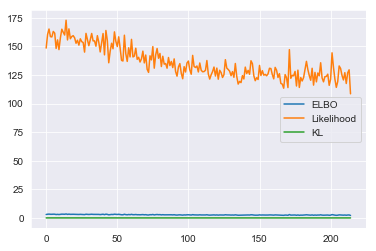

In [155]:
tot_loss_flatten = [item for sublist in tot_loss for item in sublist]

pd.DataFrame(np.matrix(tot_loss_flatten), columns = ['ELBO', 'Likelihood', 'KL']).plot()

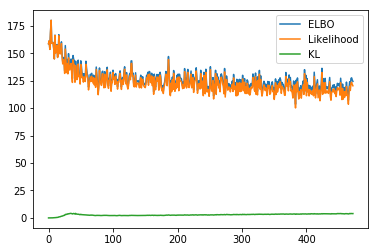

In [151]:
# This is from beta=0

tot_loss_flatten = [item for sublist in tot_loss for item in sublist]

pd.DataFrame(np.matrix(tot_loss_flatten), columns = ['ELBO', 'Likelihood', 'KL']).plot()

In [150]:
# OMG! The multinomial loss dominates completely => we can't really learn the encoder... :crying cat face:
# => Need to change loss, or multiply the KL-term with some constant beta?
# NOTE: It might also be a bug in the code above: the log likelihood should not be that big. 
#
# Recall that the likelihood is calculated from log p, and if p is veeery small 
# (which it has be from softmax of a lot of likely tokens)

# Cold start on users

How does this model fix the cold start problem for users?

It doesn't really, but since users are represented completely by their click vector, no retraining is needed when new users flow into the product.

Now, let us validate!

In [141]:
# Validation set will contain all items for all history, excluding new tokens only seen from March
valset = counts_val[counts_val['token'].isin(counts['token']) & counts_val['author'].isin(counts['author'])]

counts_val_ = pd.concat([valset, counts]).groupby(["token", "author"]).size().reset_index()

# Weights matrix
(interactions_val, weights_val) = d.build_interactions(((x['author'], x['token'], x[0]) for i, x in counts_val.iterrows()))

# And a matrix for validation
val_matrix = interactions_val.todense()

## Recall at K

Let algorithm pick top K items from validation set, and check how many of the total number of positive times are in this set.

## Precision at K

Let algorithm pick top K items from validation set, and check how many of those chosen are positive.


Note:

A random model produces ~1-2 % in precision and recall.

In [142]:
sum_per_u = val_matrix.sum(axis=1)

In [156]:
# Run the full training set through the model
(logpi, _, _)  = vae.forward(train_tensor.to_dense(), is_training=False)

preds = logpi.detach().numpy()

In [157]:
k = 10
recall = []
precision = []
for a in range(preds.shape[0]):
    topk = preds[a, :].argsort()[-k:]
    if sum_per_u[a] > 0:
        recall.append(val_matrix[a, topk].sum()/sum_per_u[a])
    precision.append(val_matrix[a, topk].mean())

print(np.array(recall).mean())
print(np.array(precision).mean())

0.11305132174361407
0.013205091803899303


In [ ]:
# Previous run
0.1753626889215187
0.2157354913077231